<a href="https://colab.research.google.com/github/mjpuma/MartimePorts/blob/main/maritime_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MARITIME ANALYSIS

In [1]:
# DATA HANDLING AND COMPUTATION
import pandas as pd
import numpy as np
from scipy.stats import linregress, pearsonr

# VISUALIZATION
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, ListedColormap
import matplotlib.cm as cm

# GEOGRAPHIC DATA
import geopandas as gpd

# NETWORK ANALYSIS
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

# INTERACTIVE DISPLAY
from IPython.display import display, HTML
import base64  # Import the base64 library

# MISCELLANEOUS
import random
import requests

In [2]:
file_url = 'https://drive.google.com/uc?export=download&id=1hgsdvkPWi1zSar7xquSqvRs-xl0kwfpJ'

maritime_data = pd.read_csv(file_url)

In [3]:
# Display the first few rows of the dataset
print("Dataset Preview:")
display(maritime_data)

Dataset Preview:


,from_name,to_name,from_id,to_id,from_iso3,to_iso3,distance,transit_hours,transit_days,capacity_daily,from_lat,from_lon,to_lat,to_lon
0,Abbot Point_Australia,Abidjan_Cote d'Ivoire,port0,port4,AUS,CIV,20939.388486,523.484712,21.811863,67.985721,-19.893755,148.077620,5.283956,-4.010908
1,Abbot Point_Australia,Acajutla_El Salvador,port0,port6,AUS,SLV,15891.115016,397.277875,16.553245,78.453797,-19.893755,148.077620,13.575440,-89.829672
2,Abbot Point_Australia,Ash Shariqah_United Arab Emirates,port0,port72,AUS,ARE,12286.590187,307.164755,12.798531,83.138699,-19.893755,148.077620,25.363127,55.376233
3,Abbot Point_Australia,Bahia Quintero (Ventanas)_Chile,port0,port90,AUS,CHL,16443.843851,411.096096,17.129004,33.300538,-19.893755,148.077620,-32.766963,-71.483951
4,Abbot Point_Australia,Balikpapa_Indonesia,port0,port102,AUS,IDN,5151.210453,128.780261,5.365844,50.930584,-19.893755,148.077620,-1.202534,116.795980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155516,rada Punta Arenas_Chile,Tauranga_New Zealand,port1432,port1278,CHL,NZL,13413.431301,335.335783,13.972324,73.266565,-53.130331,-70.867852,-37.660488,176.184633
155517,rada Punta Arenas_Chile,Ulsan_South Korea,port1432,port1338,CHL,KOR,21024.686180,525.617155,21.900715,148.330629,-53.130331,-70.867852,35.486473,129.378084
155518,rada Punta Arenas_Chile,Whangerei_New Zealand,port1432,port1393,CHL,NZL,13377.990291,334.449757,13.935407,48.316730,-53.130331,-70.867852,-35.842383,174.488189
155519,rada Punta Arenas_Chile,Zhapu_China,port1432,port1427,CHL,CHN,22180.417591,554.510440,23.104602,92.602235,-53.130331,-70.867852,30.636885,121.156883


-------
#### 1. CAPACITY-BASED METRICS
- Daily handling capacity (min, max, mean per port)
- Total throughput volumes
- Variation in capacity (standard deviation, coefficient of variation)
- Seasonality patterns if present <span style="color: red;">(need a time-based data)</span>



In [4]:
# Compute daily handling capacity metrics
port_capacity = maritime_data.groupby('to_name')['capacity_daily'].agg(['mean', 'min', 'max', 'std'])

# Rename index to 'port_name'
port_capacity.index.name = 'port_name'

# Add coefficient of variation (std/mean)
port_capacity['coeff_variation'] = port_capacity['std'] / port_capacity['mean']

# Compute total throughput volumes
total_throughput = maritime_data.groupby('to_name')['capacity_daily'].sum()

# Merge throughput volumes into the capacity metrics table
port_capacity = port_capacity.merge(total_throughput.rename('total_throughput'), left_index=True, right_index=True)

# Reset the index for easier readability
port_capacity = port_capacity.reset_index()

# Display the final dataframe
display(port_capacity)


,port_name,mean,min,max,std,coeff_variation,total_throughput
0,Abbot Point_Australia,288.437618,23.145125,2923.514238,418.055415,1.449379,43265.642741
1,Abenra_Denmark,85.242691,1.678082,1613.953020,199.015255,2.334690,10484.850984
2,Aberdeen_U.S.A.,72.617900,14.106155,394.671075,85.420656,1.176303,4647.545583
3,Aberdeen_United Kingdom,39.041404,1.029578,1020.474540,117.225813,3.002602,5778.127750
4,Abidjan_Cote d'Ivoire,434.826678,0.792954,16966.105111,1682.364150,3.869045,90009.122433
...,...,...,...,...,...,...,...
1404,Zhouliwang_China,886.019230,0.160290,12114.201670,1922.785835,2.170140,169229.672884
1405,Zhoushan_China,723.275990,0.000000,29932.689727,2391.448109,3.306412,279184.532180
1406,Zonguldak_Turkey,259.524823,1.623665,6241.414827,802.586554,3.092523,29326.305017
1407,palma De Mallorca_Spain,68.382980,4.108423,557.029381,114.353770,1.672255,4513.276699


#### 2. GEOGRAPHIC ANALYSIS  
- Distance from Ukraine's ports (use haversine formula)
- Regional/continental distribution of receiving ports
- Clustering analysis based on location
- Maritime route dependencies


 code snippet:

```python
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    # ... rest of haversine formula
```

In [5]:
# HAVERSINE FORMULA

# Haversine formula to calculate the great-circle distance
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])  # Convert degrees to radians
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

In [6]:
# Create a new column 'distance_haversine' in maritime_data by applying the haversine_distance function
maritime_data['distance_haversine'] = maritime_data.apply(
    lambda row: haversine_distance(
        row['from_lat'], row['from_lon'], row['to_lat'], row['to_lon']
    ),
    axis=1
)

display(maritime_data)


,from_name,to_name,from_id,to_id,from_iso3,to_iso3,distance,transit_hours,transit_days,capacity_daily,from_lat,from_lon,to_lat,to_lon,distance_haversine
0,Abbot Point_Australia,Abidjan_Cote d'Ivoire,port0,port4,AUS,CIV,20939.388486,523.484712,21.811863,67.985721,-19.893755,148.077620,5.283956,-4.010908,16587.605952
1,Abbot Point_Australia,Acajutla_El Salvador,port0,port6,AUS,SLV,15891.115016,397.277875,16.553245,78.453797,-19.893755,148.077620,13.575440,-89.829672,13836.766791
2,Abbot Point_Australia,Ash Shariqah_United Arab Emirates,port0,port72,AUS,ARE,12286.590187,307.164755,12.798531,83.138699,-19.893755,148.077620,25.363127,55.376233,11198.228266
3,Abbot Point_Australia,Bahia Quintero (Ventanas)_Chile,port0,port90,AUS,CHL,16443.843851,411.096096,17.129004,33.300538,-19.893755,148.077620,-32.766963,-71.483951,12807.101031
4,Abbot Point_Australia,Balikpapa_Indonesia,port0,port102,AUS,IDN,5151.210453,128.780261,5.365844,50.930584,-19.893755,148.077620,-1.202534,116.795980,3985.936418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155516,rada Punta Arenas_Chile,Tauranga_New Zealand,port1432,port1278,CHL,NZL,13413.431301,335.335783,13.972324,73.266565,-53.130331,-70.867852,-37.660488,176.184633,8042.316986
155517,rada Punta Arenas_Chile,Ulsan_South Korea,port1432,port1338,CHL,KOR,21024.686180,525.617155,21.900715,148.330629,-53.130331,-70.867852,35.486473,129.378084,17494.865630
155518,rada Punta Arenas_Chile,Whangerei_New Zealand,port1432,port1393,CHL,NZL,13377.990291,334.449757,13.935407,48.316730,-53.130331,-70.867852,-35.842383,174.488189,8294.592562
155519,rada Punta Arenas_Chile,Zhapu_China,port1432,port1427,CHL,CHN,22180.417591,554.510440,23.104602,92.602235,-53.130331,-70.867852,30.636885,121.156883,17331.570791


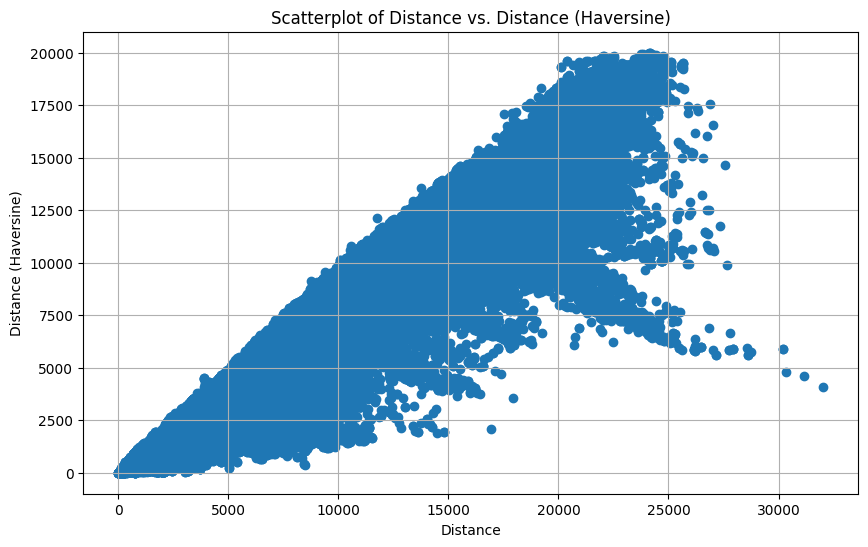

In [7]:
# prompt: create a scatterplot of distance and distance_haversine

plt.figure(figsize=(10, 6))
plt.scatter(maritime_data['distance'], maritime_data['distance_haversine'])
plt.xlabel('Distance')
plt.ylabel('Distance (Haversine)')
plt.title('Scatterplot of Distance vs. Distance (Haversine)')
plt.grid(True)
plt.show()

In [8]:
# Initialize an empty DataFrame to store all ports
all_ports = pd.DataFrame(columns=['port_name', 'port_id', 'port_lat', 'port_lon', 'port_iso3'])

# Combine unique 'from' and 'to' port data from maritime_data
from_ports = maritime_data[['from_name', 'from_id', 'from_lat', 'from_lon', 'from_iso3']].rename(
    columns={'from_name': 'port_name', 'from_id': 'port_id', 'from_lat': 'port_lat', 'from_lon': 'port_lon', 'from_iso3': 'port_iso3'}
)

to_ports = maritime_data[['to_name', 'to_id', 'to_lat', 'to_lon', 'to_iso3']].rename(
    columns={'to_name': 'port_name', 'to_id': 'port_id', 'to_lat': 'port_lat', 'to_lon': 'port_lon', 'to_iso3': 'port_iso3'}
)

# Concatenate the 'from' and 'to' ports
all_ports = pd.concat([from_ports, to_ports], ignore_index=True)

# Drop duplicate ports based on 'port_id'
all_ports = all_ports.drop_duplicates(subset=['port_id']).reset_index(drop=True)

# Display the 'all_ports' DataFrame
display(all_ports)


,port_name,port_id,port_lat,port_lon,port_iso3
0,Abbot Point_Australia,port0,-19.893755,148.077620,AUS
1,Abenra_Denmark,port1,55.042542,9.428137,DNK
2,Aberdeen_U.S.A.,port2,46.965982,-123.847752,USA
3,Aberdeen_United Kingdom,port3,57.139929,-2.076617,GBR
4,Abidjan_Cote d'Ivoire,port4,5.283956,-4.010908,CIV
...,...,...,...,...,...
1405,Zhoushan_China,port1429,30.056350,122.100837,CHN
1406,Zonguldak_Turkey,port1430,41.500894,31.870638,TUR
1407,palma De Mallorca_Spain,port1431,39.554120,2.632706,ESP
1408,rada Punta Arenas_Chile,port1432,-53.130331,-70.867852,CHL


In [9]:
# Define the continent assignments
continent_mapping = {
    "ASIA": ["YEM", "JOR", "HKG", "KHM", "LKA", "TKM", "MMR", "BRN", "MAC", "ARE", "AZE", "BHR", "BGD", "CHN", "CYP", "GEO", "IDN", "IND", "IRN", "IRQ", "ISR", "JPN", "KAZ", "KOR", "KWT", "LBN", "MDV", "MYS", "OMN", "PAK", "PHL", "QAT", "SAU", "SGP", "SYR", "THA", "TLS", "TUR", "TWN", "UAE", "VNM"],
    "EURO": ["GIB", "JEY", "GGY", "MAF", "GLP", "BLM", "ALB", "AND", "AUT", "BEL", "BGR", "BIH", "CHE", "CZE", "DEU", "DNK", "ESP", "EST", "FIN", "FRA", "GBR", "GRC", "HRV", "HUN", "IRL", "ISL", "ITA", "LIE", "LTU", "LUX", "LVA", "MCO", "MDA", "MKD", "MLT", "MNE", "NLD", "NOR", "POL", "PRT", "ROU", "RUS", "SMR", "SRB", "SVN", "SWE", "UKR", "VAT"],
    "AUST": ["NIU", "GUM", "NCL", "MNP", "ASM", "AUS", "COK", "FJI", "FSM", "KIR", "MHL", "NRU", "NZL", "PLW", "PNG", "PYF", "SLB", "TON", "TUV", "VUT", "WSM"],
    "AFRI": ["ESH", "MAR", "MYT", "SYC", "AGO", "BEN", "BFA", "BWA", "CAF", "CIV", "CMR", "COD", "COG", "COM", "CPV", "DJI", "DZA", "EGY", "ERI", "ETH", "GAB", "GHA", "GIN", "GMB", "GNB", "GNQ", "KEN", "LBR", "LBY", "MDG", "MLI", "MOZ", "MRT", "MUS", "NAM", "NGA", "REU", "RWA", "SDN", "SEN", "SLE", "SOM", "STP", "SWZ", "TCD", "TGO", "TUN", "TZA", "UGA", "ZAF", "ZMB", "ZWE"],
    "NOAM": ["MTQ", "BRB", "VIR", "SXM", "CYM", "VCT", "ABW", "BES", "CUW", "AIA", "ATG", "BHS", "BLZ", "BMU", "CAN", "CRI", "CUB", "DMA", "DOM", "GRD", "GTM", "HND", "HTI", "JAM", "KNA", "LCA", "MEX", "MSR", "NIC", "PAN", "PRI", "SLV", "TCA", "TTO", "USA", "VGB"],
    "SOAM": ["GUF", "ARG", "BOL", "BRA", "CHL", "COL", "ECU", "GUY", "PER", "PRY", "SUR", "URY", "VEN"]
}

# Function to map ISO3 code to continent
def get_continent(iso3):
    for continent, iso3_codes in continent_mapping.items():
        if iso3 in iso3_codes:
            return continent
    return "Unknown"  # Default if ISO3 code is not found

# Apply the function to the all_ports DataFrame
all_ports['continent'] = all_ports['port_iso3'].apply(get_continent)

# Display the updated DataFrame
display(all_ports)


,port_name,port_id,port_lat,port_lon,port_iso3,continent
0,Abbot Point_Australia,port0,-19.893755,148.077620,AUS,AUST
1,Abenra_Denmark,port1,55.042542,9.428137,DNK,EURO
2,Aberdeen_U.S.A.,port2,46.965982,-123.847752,USA,NOAM
3,Aberdeen_United Kingdom,port3,57.139929,-2.076617,GBR,EURO
4,Abidjan_Cote d'Ivoire,port4,5.283956,-4.010908,CIV,AFRI
...,...,...,...,...,...,...
1405,Zhoushan_China,port1429,30.056350,122.100837,CHN,ASIA
1406,Zonguldak_Turkey,port1430,41.500894,31.870638,TUR,ASIA
1407,palma De Mallorca_Spain,port1431,39.554120,2.632706,ESP,EURO
1408,rada Punta Arenas_Chile,port1432,-53.130331,-70.867852,CHL,SOAM


In [10]:
# prompt: Using dataframe all_ports: display row that has unknown in the continent

# Display rows where the continent is "Unknown"
all_ports[all_ports["continent"] == "Unknown"]


,port_name,port_id,port_lat,port_lon,port_iso3,continent


In [11]:
# prompt: Using dataframe all_ports: export all_ports to csv and download

from IPython.display import HTML
import pandas as pd
# Save the dataframe to a csv file
all_ports.to_csv('all_ports.csv', index=False)

# Create a download link for the csv file
def create_download_link(df, title = "Download CSV file", filename = "all_ports.csv"):
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# Display the download link
create_download_link(all_ports)


In [12]:
# Create a new dataframe containing only the rows where the 'port_iso3' column is 'UKR'.
ukraine_ports = all_ports[all_ports['port_iso3'] == 'UKR']
display(ukraine_ports)


,port_name,port_id,port_lat,port_lon,port_iso3,continent
133,Bedyansk_Ukraine,port135,46.752471,36.776569,UKR,EURO
485,Illichivsk_Ukraine,port489,46.331599,30.656566,UKR,EURO
555,Kerch_Ukraine,port559,45.337536,36.463934,UKR,EURO
699,Mariupol_Ukraine,port707,47.054354,37.505079,UKR,EURO
773,Mykolayiv_Ukraine,port782,46.939475,32.015560,UKR,EURO
833,Odesa_Ukraine,port843,46.501283,30.738071,UKR,EURO
1395,Yuzhnyy_Ukraine,port1419,46.633347,31.018057,UKR,EURO


In [13]:
# Create an empty list to store connection details
connections = []

# Iterate through each ukraine_ports
for _, ukraine_ports in ukraine_ports.iterrows():
    # Find connected ports in maritime_data
    connected_ports = maritime_data[
        (maritime_data['from_name'] == ukraine_ports['port_name']) |
        (maritime_data['to_name'] == ukraine_ports['port_name'])
    ]

    # Iterate through the connected ports
    for _, connected_port_row in connected_ports.iterrows():
        # Determine connected port's details
        if connected_port_row['from_name'] == ukraine_ports['port_name']:
            connected_port_name = connected_port_row['to_name']
            connected_lat = connected_port_row['to_lat']
            connected_lon = connected_port_row['to_lon']
            connected_iso3 = connected_port_row['to_iso3']
            distance = connected_port_row['distance']
        else:
            connected_port_name = connected_port_row['from_name']
            connected_lat = connected_port_row['from_lat']
            connected_lon = connected_port_row['from_lon']
            connected_iso3 = connected_port_row['from_iso3']
            distance = connected_port_row['distance']

        # Append the connection details to the list
        connections.append([
            ukraine_ports['port_name'], ukraine_ports['port_lat'], ukraine_ports['port_lon'],
            ukraine_ports['port_iso3'], ukraine_ports['continent'],
            connected_port_name, connected_lat, connected_lon, connected_iso3,
            get_continent(connected_iso3), distance
        ])

# Create the ukraine_connections DataFrame
ukraine_connections = pd.DataFrame(connections, columns=[
    'ukraine_port', 'ukraine_lat', 'ukraine_lon', 'ukraine_iso3', 'ukraine_continent',
    'connected_port', 'connected_lat', 'connected_lon', 'connected_iso3', 'connected_continent', 'distance_haversine'
])

# Display the ukraine_connections DataFrame
display(ukraine_connections)


,ukraine_port,ukraine_lat,ukraine_lon,ukraine_iso3,ukraine_continent,connected_port,connected_lat,connected_lon,connected_iso3,connected_continent,distance_haversine
0,Bedyansk_Ukraine,46.752471,36.776569,UKR,EURO,Aden_Yemen,12.781866,44.954943,YEM,ASIA,5139.740775
1,Bedyansk_Ukraine,46.752471,36.776569,UKR,EURO,Al Iskandariyh (Alexandria)_Egypt,31.155365,29.837591,EGY,AFRI,2847.624457
2,Bedyansk_Ukraine,46.752471,36.776569,UKR,EURO,Al Ladhiqiyah_Syria,35.523600,35.770449,SYR,ASIA,2867.604952
3,Bedyansk_Ukraine,46.752471,36.776569,UKR,EURO,Al Mukalla_Yemen,14.520611,49.151230,YEM,ASIA,5990.896942
4,Bedyansk_Ukraine,46.752471,36.776569,UKR,EURO,Algeciras_Spain,36.165922,-5.414267,ESP,EURO,5098.234408
...,...,...,...,...,...,...,...,...,...,...,...
2372,Yuzhnyy_Ukraine,46.633347,31.018057,UKR,EURO,Zhanjiang_China,21.212128,110.408410,CHN,ASIA,14316.049024
2373,Yuzhnyy_Ukraine,46.633347,31.018057,UKR,EURO,Zhoushan_China,30.056350,122.100837,CHN,ASIA,15355.164905
2374,Yuzhnyy_Ukraine,46.633347,31.018057,UKR,EURO,Zonguldak_Turkey,41.500894,31.870638,TUR,ASIA,724.743832
2375,Yuzhnyy_Ukraine,46.633347,31.018057,UKR,EURO,Zhanjiang_China,21.212128,110.408410,CHN,ASIA,14316.049024


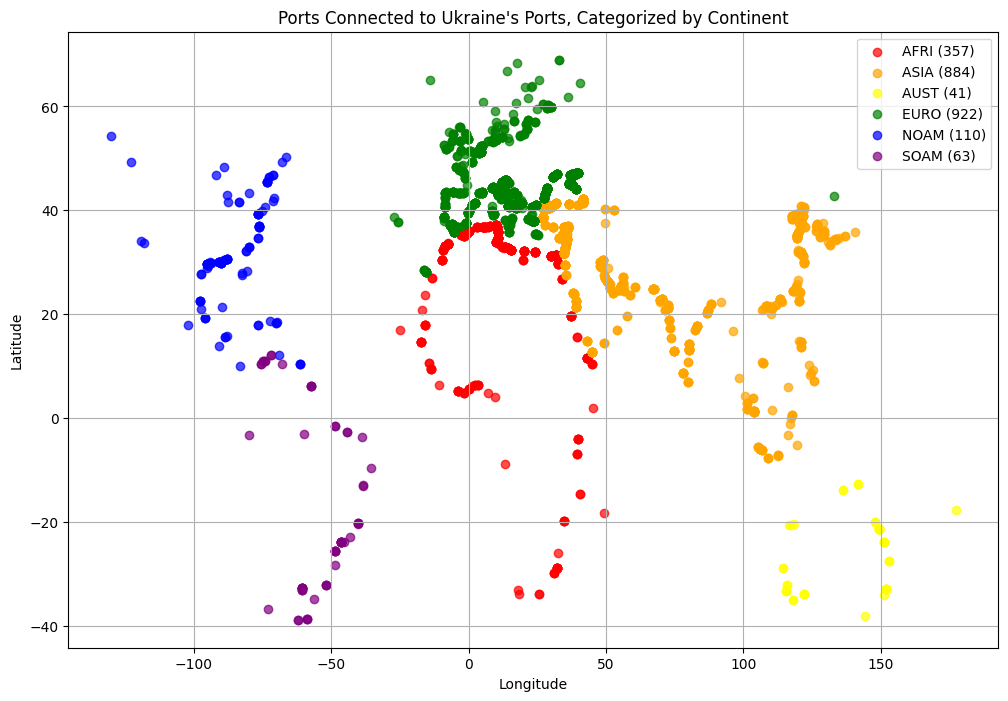

In [14]:
# prompt: Using dataframe ukraine_connections: Write Python code to visualize the ports connected to Ukraine's ports, categorized by continent, using latitude and longitude coordinates. Use the matplotlib library to create a scatter plot. Assign distinct bright colors to each continent: red for Africa (AFRC), orange for Asia (ASIA), yellow for Australia (AUST), green for Europe (EURO), blue for North America (NOAM), and purple for South America (SOAM). Include a legend showing the continent names and the number of connected ports in parentheses. Add gridlines, labels for latitude and longitude, and a title. Data comes from two merged DataFrames: one with connection details and another with country-continent mapping. Ensure the plot is clear and visually appealing.

import matplotlib.pyplot as plt

# Define continent colors
continent_colors = {
    'AFRI': 'red',
    'ASIA': 'orange',
    'AUST': 'yellow',
    'EURO': 'green',
    'NOAM': 'blue',
    'SOAM': 'purple'
}

# Create the scatter plot
plt.figure(figsize=(12, 8))  # Adjust figure size for better visualization

for continent, color in continent_colors.items():
    subset = ukraine_connections[ukraine_connections['connected_continent'] == continent]
    plt.scatter(subset['connected_lon'], subset['connected_lat'],
                color=color, label=f'{continent} ({len(subset)})', alpha=0.7)

# Add gridlines, labels, and title
plt.grid(True)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Ports Connected to Ukraine's Ports, Categorized by Continent")

# Add a legend with continent names and number of connected ports
plt.legend()

# Display the plot
plt.show()

2.3 Clustering Analysis Based on Location

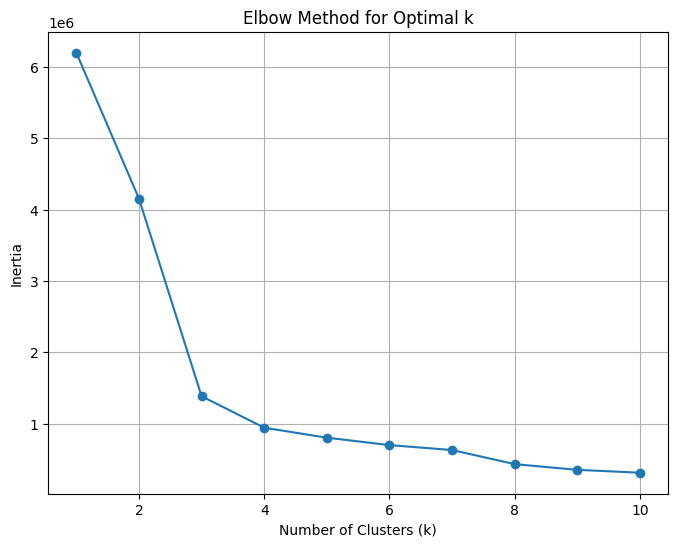

In [15]:
from sklearn.cluster import KMeans

# Prepare the data for clustering
X = ukraine_connections[['connected_lat', 'connected_lon']].values

# Determine the optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

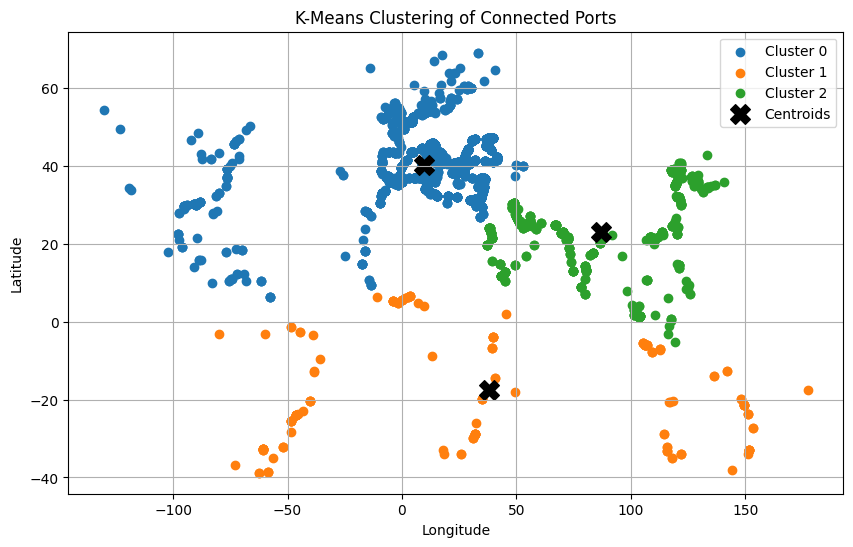

Cluster Summary:


,Cluster ID,Port Count
0,0,1690
1,1,168
2,2,519


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'ukraine_connections' DataFrame is already created as in the provided code

# 1. Standardize Latitude and Longitude
scaler = StandardScaler()
X_scaled = scaler.fit_transform(ukraine_connections[['connected_lat', 'connected_lon']])

# 2. Perform K-Means Clustering
n_clusters = 3  # Specify the desired number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
ukraine_connections['cluster'] = kmeans.fit_predict(X_scaled)

# 3. Visualize Clusters
plt.figure(figsize=(10, 6))

# Inverse transform cluster centroids to original scale for plotting
centroids_original_scale = scaler.inverse_transform(kmeans.cluster_centers_)


for cluster_id in range(n_clusters):
    cluster_data = ukraine_connections[ukraine_connections['cluster'] == cluster_id]
    plt.scatter(cluster_data['connected_lon'], cluster_data['connected_lat'], label=f'Cluster {cluster_id}')

plt.scatter(centroids_original_scale[:, 1], centroids_original_scale[:, 0], marker='X', s=200, color='black', label='Centroids')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clustering of Connected Ports')
plt.legend()
plt.grid(True)
plt.show()

# 4. Summarize Cluster Results
cluster_summary = ukraine_connections.groupby('cluster').size().reset_index(name='Port Count')
cluster_summary = cluster_summary.rename(columns={'cluster': 'Cluster ID'})
print("Cluster Summary:")
cluster_summary

2.4 Maritime Route Dependencies

In [17]:
# Create a graph
maritime_network = nx.Graph()

# Add nodes representing ports
for index, row in all_ports.iterrows():
    maritime_network.add_node(row['port_name'])

# Add edges representing connections between ports
for index, row in maritime_data.iterrows():
    maritime_network.add_edge(row['from_name'], row['to_name'])

# Check if the graph is fully connected
is_fully_connected = nx.is_connected(maritime_network)

# Print the result
if is_fully_connected:
    print("The maritime network is fully connected.")
else:
    print("The maritime network is not fully connected.")

The maritime network is fully connected.


In [18]:
# Create a directed graph
G_directed = nx.DiGraph()

# Add edges to the graph
for _, row in maritime_data.iterrows():
    G_directed.add_edge(row['from_name'], row['to_name'])

# Check if the graph is strongly connected
is_strongly_connected = nx.is_strongly_connected(G_directed)

if is_strongly_connected:
    print("The directed network is strongly connected.")
else:
    print("The directed network is NOT strongly connected.")

The directed network is NOT strongly connected.


In [19]:
if not is_strongly_connected:
    # Identify nodes that are not part of the largest strongly connected component
    largest_scc = max(nx.strongly_connected_components(G_directed), key=len)
    non_connected_ports = set(G_directed.nodes) - largest_scc

    # Display the ports that are not strongly connected
    non_connected_ports_list = list(non_connected_ports)
    non_connected_ports_list[:100]  # Display the first 100 for brevity
else:
    non_connected_ports_list = []

non_connected_ports_list

['La Ceiba_Honduras', 'Nitti_Sierra Leone']


### 3. PORT CHARACTERISTICS
- Port size categories (based on capacity quantiles)
- Number of unique connections per port
- Types of shipping routes served
- Regularity of service (frequency analysis) #later

Code snippet:
```python
port_categories = pd.qcut(maritime_data.groupby('to_name')['capacity_daily'].mean(),
                         q=4, labels=['Small', 'Medium', 'Large', 'Very Large'])
```

#### 3.1 Port size categories (based on capacity quantiles)

In [20]:
# Step 1: Extract 'port_name' and 'max' capacity from port_capacity dataframe
port_capacity_max = port_capacity[['port_name', 'max']].copy()

# Step 2: Categorize ports into four size categories based on quantiles
port_capacity_max['size_category'] = pd.qcut(
    port_capacity_max['max'],
    q=4,  # Divide into 4 quantiles
    labels=['Small', 'Medium', 'Large', 'Very Large']
)

# Step 3: Display the port capacity dataframe with the new size category column
display(port_capacity_max)

# Step 4: Group by size category and calculate summary statistics
size_category_stats = port_capacity_max.groupby('size_category')['max'].agg(
    mean='mean',
    median='median',
    max='max',
    min='min',
    std='std'
).reset_index()

# Add port count as the second column
port_counts = port_capacity_max['size_category'].value_counts().sort_index().reset_index()
port_counts.columns = ['size_category', 'port_count']

# Merge the port count into the summary stats
size_category_stats = port_counts.merge(size_category_stats, on='size_category')

# Display the summary statistics
display(size_category_stats)

,port_name,max,size_category
0,Abbot Point_Australia,2923.514238,Large
1,Abenra_Denmark,1613.953020,Medium
2,Aberdeen_U.S.A.,394.671075,Small
3,Aberdeen_United Kingdom,1020.474540,Medium
4,Abidjan_Cote d'Ivoire,16966.105111,Very Large
...,...,...,...
1404,Zhouliwang_China,12114.201670,Very Large
1405,Zhoushan_China,29932.689727,Very Large
1406,Zonguldak_Turkey,6241.414827,Large
1407,palma De Mallorca_Spain,557.029381,Small


<ipython-input-20-139665944ab2>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_category_stats = port_capacity_max.groupby('size_category')['max'].agg(


,size_category,port_count,mean,median,max,min,std
0,Small,353,307.352550,292.406299,733.372448,0.544423,206.832661
1,Medium,352,1427.867013,1374.875027,2442.228143,736.959040,484.780199
2,Large,352,4720.301781,4048.300094,8938.976827,2461.744081,1869.578298
3,Very Large,352,38359.039609,20333.325464,510646.260964,8939.887424,54711.276146


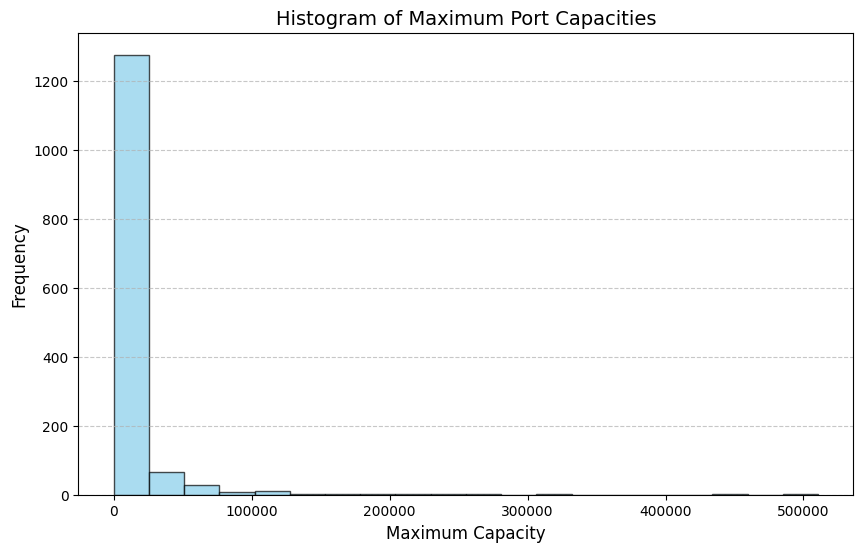

In [21]:
import matplotlib.pyplot as plt

# Extract the maximum capacity values from the port_capacity DataFrame
max_capacity_values = port_capacity['max']

# Plot a histogram for the maximum capacity values
plt.figure(figsize=(10, 6))
plt.hist(max_capacity_values, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Maximum Port Capacities', fontsize=14)
plt.xlabel('Maximum Capacity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#### 3.2 Number of unique connections per port

,port_name,unique_connections
110,Rotterdam_Netherlands,834
248,Singapore_Singapore,767
154,Antwerp_Belgium,751
119,Shanghai_China,669
229,New Orleans_U.S.A.,656
...,...,...
1402,Kilifi_Kenya,1
1404,La Ceiba_Honduras,1
1371,Dover_Australia,1
1345,Cabanas_Cuba,1


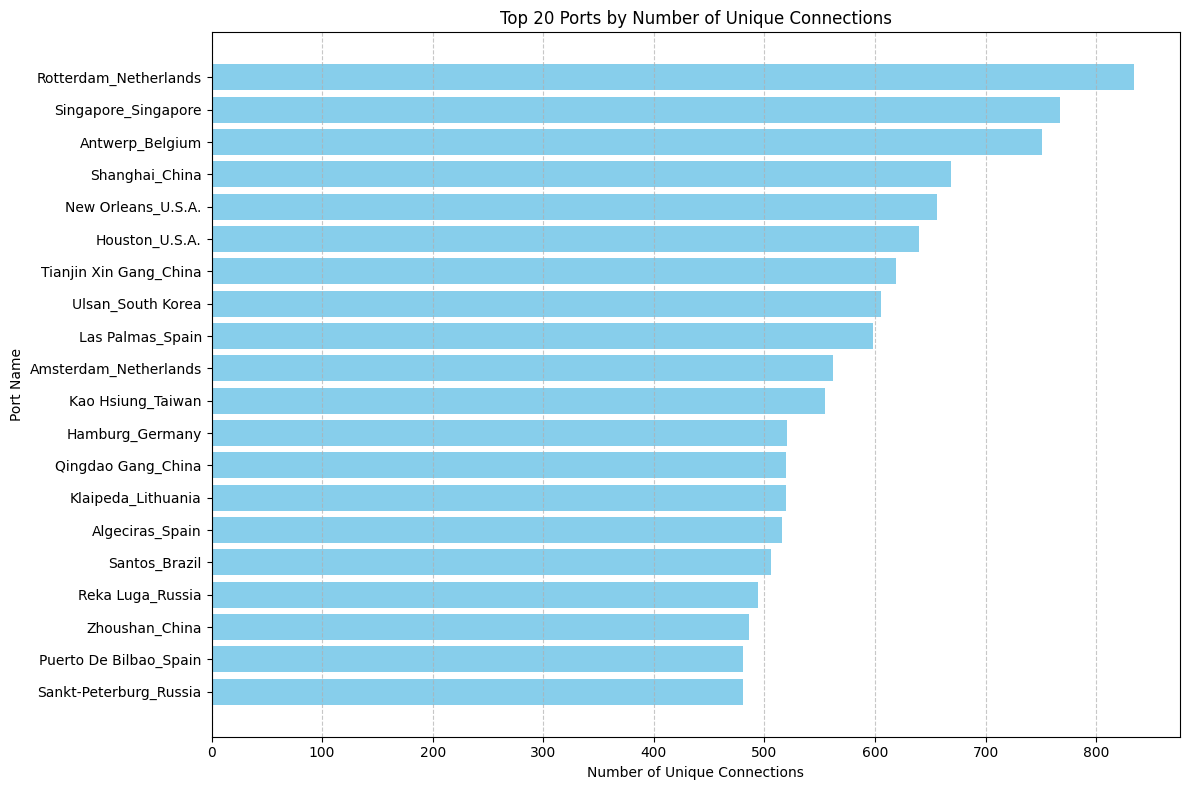

In [22]:
# Step 1: Combine 'from_name' and 'to_name' into a single undirected connection
# Each pair of ports should only be counted once regardless of direction
connections = maritime_data[['from_name', 'to_name']].drop_duplicates()
connections = connections.apply(frozenset, axis=1).drop_duplicates()

# Step 2: Create a mapping of each port to its unique connections
port_connections = {}
for connection in connections:
    port_list = list(connection)
    if len(port_list) == 2:
        port1, port2 = port_list
        port_connections.setdefault(port1, set()).add(port2)
        port_connections.setdefault(port2, set()).add(port1)

# Step 3: Count unique connections for each port
unique_connections = {port: len(connected_ports) for port, connected_ports in port_connections.items()}

# Step 4: Convert the results to a DataFrame
unique_connections_df = pd.DataFrame.from_dict(unique_connections, orient='index', columns=['unique_connections'])
unique_connections_df.reset_index(inplace=True)
unique_connections_df.columns = ['port_name', 'unique_connections']

# Step 5: Sort the results
unique_connections_df_sorted = unique_connections_df.sort_values(by='unique_connections', ascending=False)

# Display the corrected DataFrame
display(unique_connections_df_sorted)

# Step 6: Visualize the corrected data
plt.figure(figsize=(12, 8))
plt.barh(unique_connections_df_sorted['port_name'][:20], unique_connections_df_sorted['unique_connections'][:20], color='skyblue')
plt.xlabel('Number of Unique Connections')
plt.ylabel('Port Name')
plt.title('Top 20 Ports by Number of Unique Connections')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### 3.3 Histogram of shipping routes served

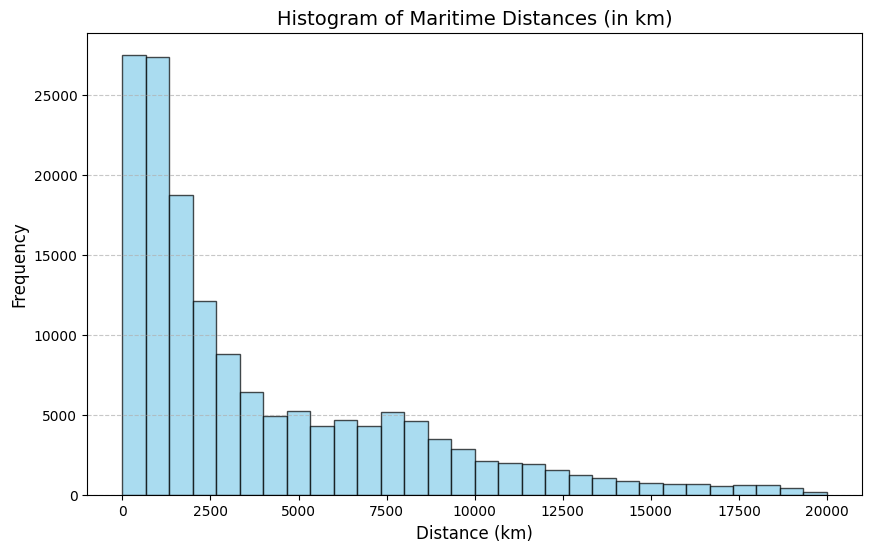

In [23]:
import matplotlib.pyplot as plt

# Plot the histogram for 'distance_haversine'
plt.figure(figsize=(10, 6))
plt.hist(maritime_data['distance_haversine'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Maritime Distances (in km)', fontsize=14)
plt.xlabel('Distance (km)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Full Network Metrics:
Nodes: 1410.000000
Edges: 155521.000000
Density: 0.078281
Average Clustering: 0.510160

Ukraine Network Metrics:
Nodes: 564.000000
Edges: 1639.000000
Density: 0.005162
Average Clustering: 0.676811


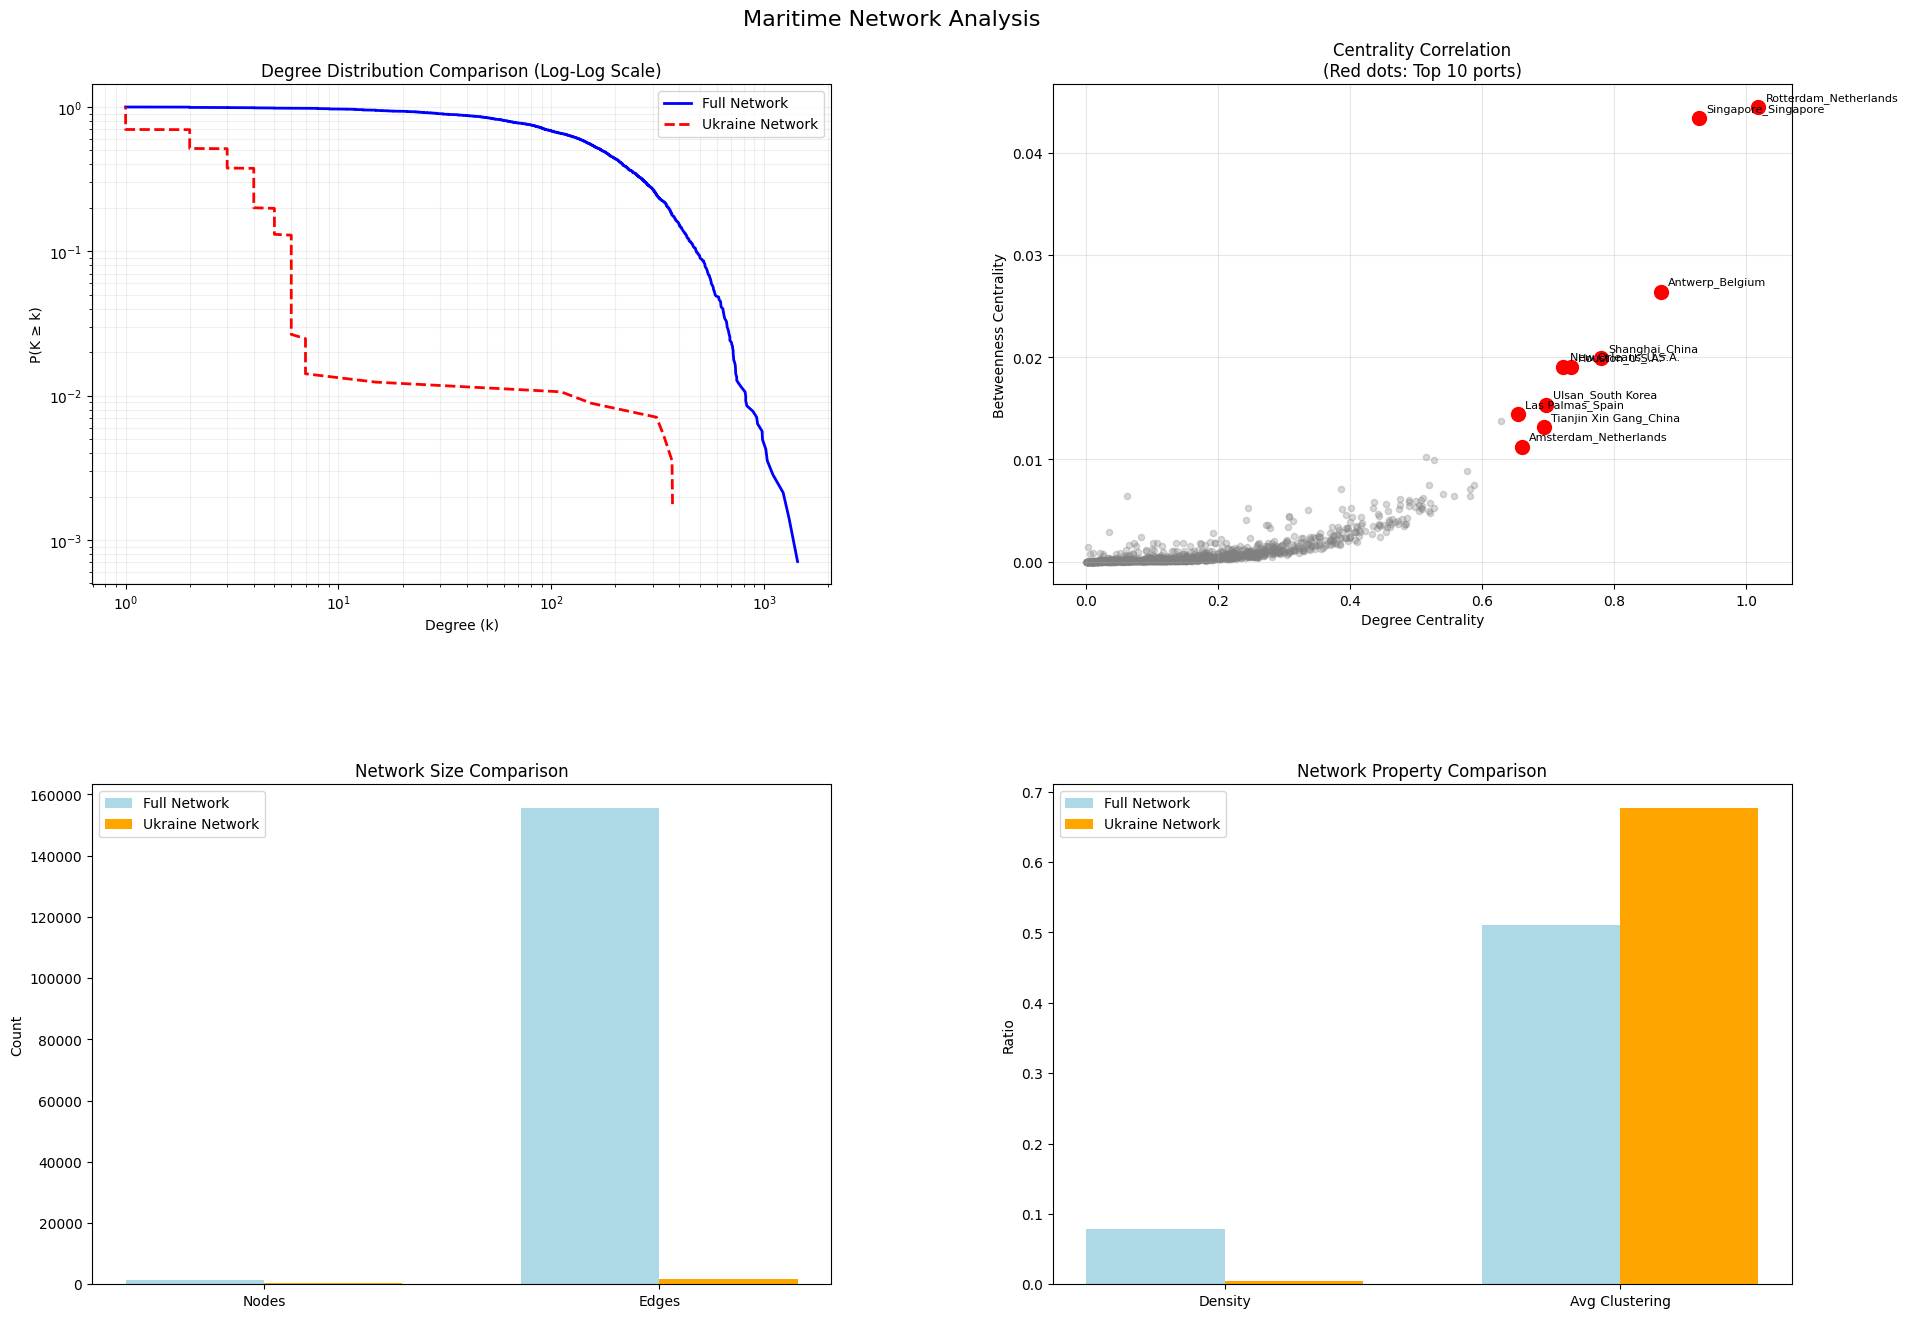


Calculating centrality metrics...

Top 20 Ports by Overall Centrality:


,Port,Degree Centrality,Betweenness Centrality,Closeness Centrality,Overall Centrality
110,Rotterdam_Netherlands,1.018453,0.044512,0.676118,0.579694
248,Singapore_Singapore,0.928318,0.043428,0.642173,0.537973
154,Antwerp_Belgium,0.871540,0.026419,0.625612,0.507857
119,Shanghai_China,0.779986,0.019890,0.605683,0.468519
194,Houston_U.S.A.,0.733854,0.019062,0.605162,0.452692
229,New Orleans_U.S.A.,0.722498,0.019074,0.614679,0.452084
301,Ulsan_South Korea,0.696948,0.015349,0.597199,0.436499
298,Tianjin Xin Gang_China,0.694109,0.013172,0.586006,0.431096
153,Amsterdam_Netherlands,0.660752,0.011254,0.582609,0.418205
62,Las Palmas_Spain,0.654365,0.014442,0.584545,0.417784



Key Hub Ports:


,Port,Overall Centrality,Hub Type
110,Rotterdam_Netherlands,0.579694,Degree Hub Gateway Central
248,Singapore_Singapore,0.537973,Degree Hub Gateway Central
154,Antwerp_Belgium,0.507857,Degree Hub Gateway Central
119,Shanghai_China,0.468519,Degree Hub Gateway Central
194,Houston_U.S.A.,0.452692,Degree Hub Gateway Central
...,...,...,...
612,San Juan_Puerto Rico,0.238108,Gateway
990,Limetree Bay_U.S. Virgin Islands,0.235900,Gateway
895,Port Noro_Solomon Islands,0.186137,Gateway
1182,Papeete_French Polynesia,0.177595,Gateway


In [24]:
### 4. NETWORK METRICS AND ANALYSIS

## 4.1 Full Network Analysis
# Create directed graph for full network
G_directed = nx.DiGraph()
for _, row in maritime_data.iterrows():
    G_directed.add_edge(row['from_name'], row['to_name'])

# Calculate basic network metrics for full network
full_network_metrics = {
    'Nodes': G_directed.number_of_nodes(),
    'Edges': G_directed.number_of_edges(),
    'Density': nx.density(G_directed),
    'Average Clustering': nx.average_clustering(G_directed)
}

print("\nFull Network Metrics:")
for metric, value in full_network_metrics.items():
    print(f"{metric}: {value:.6f}")

## 4.2 Ukraine-Specific Network Analysis
# Create Ukraine-specific network with correct column names
G_ukraine = nx.DiGraph()
for _, row in ukraine_connections.iterrows():
    G_ukraine.add_edge(row['ukraine_port'], row['connected_port'])

ukraine_network_metrics = {
    'Nodes': G_ukraine.number_of_nodes(),
    'Edges': G_ukraine.number_of_edges(),
    'Density': nx.density(G_ukraine),
    'Average Clustering': nx.average_clustering(G_ukraine)
}

print("\nUkraine Network Metrics:")
for metric, value in ukraine_network_metrics.items():
    print(f"{metric}: {value:.6f}")

## 4.3 Network Visualization and Analysis
def plot_network_analysis(G_directed, G_ukraine):
    fig = plt.figure(figsize=(20, 15))
    # Adjust subplot parameters to give specified padding
    plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.9, wspace=0.3, hspace=0.4)

    # 1. Degree Exceedance Probability (Both Networks)
    ax1 = plt.subplot(221)
    # Full network
    degrees_full = [d for n, d in G_directed.degree()]
    degrees_full.sort(reverse=True)
    exceedance_prob_full = np.arange(1, len(degrees_full) + 1) / len(degrees_full)
    ax1.plot(degrees_full, exceedance_prob_full, 'b-', label='Full Network', linewidth=2)
    # Ukraine network
    degrees_ukraine = [d for n, d in G_ukraine.degree()]
    degrees_ukraine.sort(reverse=True)
    exceedance_prob_ukraine = np.arange(1, len(degrees_ukraine) + 1) / len(degrees_ukraine)
    ax1.plot(degrees_ukraine, exceedance_prob_ukraine, 'r--', label='Ukraine Network', linewidth=2)

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title('Degree Distribution Comparison (Log-Log Scale)')
    ax1.set_xlabel('Degree (k)')
    ax1.set_ylabel('P(K ≥ k)')
    ax1.grid(True, which="both", ls="-", alpha=0.2)
    ax1.legend()

    # 2. Centrality Measures Correlation
    ax2 = plt.subplot(222)
    # Calculate centralities
    degree_cent = nx.degree_centrality(G_directed)
    between_cent = nx.betweenness_centrality(G_directed)
    close_cent = nx.closeness_centrality(G_directed)

    # Create DataFrame for top ports
    centrality_df = pd.DataFrame({
        'Port': list(degree_cent.keys()),
        'Degree': list(degree_cent.values()),
        'Betweenness': list(between_cent.values()),
        'Closeness': list(close_cent.values())
    })

    # Plot all ports as small dots
    ax2.scatter(centrality_df['Degree'], centrality_df['Betweenness'],
                alpha=0.3, c='gray', s=20)

    # Highlight top 10 ports
    top_10 = centrality_df.nlargest(10, 'Degree')
    ax2.scatter(top_10['Degree'], top_10['Betweenness'],
                alpha=1, c='red', s=100)

    # Label top 10 ports
    for _, row in top_10.iterrows():
        ax2.annotate(row['Port'],
                    (row['Degree'], row['Betweenness']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8)

    ax2.set_xlabel('Degree Centrality')
    ax2.set_ylabel('Betweenness Centrality')
    ax2.set_title('Centrality Correlation\n(Red dots: Top 10 ports)')
    ax2.grid(True, alpha=0.3)

    # 3. Network Metrics Comparison
    ax3 = plt.subplot(223)

    # Separate metrics into two groups based on scale
    large_metrics = pd.DataFrame({
        'Metric': ['Nodes', 'Edges'],
        'Full Network': [full_network_metrics['Nodes'], full_network_metrics['Edges']],
        'Ukraine Network': [ukraine_network_metrics['Nodes'], ukraine_network_metrics['Edges']]
    })

    small_metrics = pd.DataFrame({
        'Metric': ['Density', 'Avg Clustering'],
        'Full Network': [full_network_metrics['Density'], full_network_metrics['Average Clustering']],
        'Ukraine Network': [ukraine_network_metrics['Density'], ukraine_network_metrics['Average Clustering']]
    })

    # Plot large metrics
    x = np.arange(len(large_metrics['Metric']))
    width = 0.35
    ax3.bar(x - width/2, large_metrics['Full Network'], width, label='Full Network', color='lightblue')
    ax3.bar(x + width/2, large_metrics['Ukraine Network'], width, label='Ukraine Network', color='orange')
    ax3.set_xticks(x)
    ax3.set_xticklabels(large_metrics['Metric'])
    ax3.set_ylabel('Count')
    ax3.set_title('Network Size Comparison')
    ax3.legend()

    # Add small metrics subplot
    ax3_small = plt.subplot(224)
    x_small = np.arange(len(small_metrics['Metric']))
    ax3_small.bar(x_small - width/2, small_metrics['Full Network'], width, label='Full Network', color='lightblue')
    ax3_small.bar(x_small + width/2, small_metrics['Ukraine Network'], width, label='Ukraine Network', color='orange')
    ax3_small.set_xticks(x_small)
    ax3_small.set_xticklabels(small_metrics['Metric'])
    ax3_small.set_ylabel('Ratio')
    ax3_small.set_title('Network Property Comparison')
    ax3_small.legend()

    plt.suptitle('Maritime Network Analysis', size=16, y=0.95)
    return fig

# Create and display the visualization
comparison_fig = plot_network_analysis(G_directed, G_ukraine)
plt.show()

## 4.4 Additional Network Analysis
# Calculate centrality metrics
print("\nCalculating centrality metrics...")
degree_cent = nx.degree_centrality(G_directed)
between_cent = nx.betweenness_centrality(G_directed)
close_cent = nx.closeness_centrality(G_directed)

# Create centrality DataFrame
centrality_df = pd.DataFrame({
    'Port': list(degree_cent.keys()),
    'Degree Centrality': list(degree_cent.values()),
    'Betweenness Centrality': list(between_cent.values()),
    'Closeness Centrality': list(close_cent.values())
})

# Calculate overall centrality score
centrality_df['Overall Centrality'] = (
    centrality_df['Degree Centrality'] +
    centrality_df['Betweenness Centrality'] +
    centrality_df['Closeness Centrality']
) / 3

# Display top ports
print("\nTop 20 Ports by Overall Centrality:")
display(centrality_df.nlargest(20, 'Overall Centrality'))

# Identify and display key hubs
def identify_key_hubs(centrality_df, percentile=90):
    thresholds = {
        'degree': np.percentile(centrality_df['Degree Centrality'], percentile),
        'betweenness': np.percentile(centrality_df['Betweenness Centrality'], percentile),
        'closeness': np.percentile(centrality_df['Closeness Centrality'], percentile)
    }

    key_hubs = centrality_df[
        (centrality_df['Degree Centrality'] >= thresholds['degree']) |
        (centrality_df['Betweenness Centrality'] >= thresholds['betweenness']) |
        (centrality_df['Closeness Centrality'] >= thresholds['closeness'])
    ].copy()

    key_hubs['Hub Type'] = ''
    key_hubs.loc[key_hubs['Degree Centrality'] >= thresholds['degree'], 'Hub Type'] += 'Degree Hub '
    key_hubs.loc[key_hubs['Betweenness Centrality'] >= thresholds['betweenness'], 'Hub Type'] += 'Gateway '
    key_hubs.loc[key_hubs['Closeness Centrality'] >= thresholds['closeness'], 'Hub Type'] += 'Central '

    return key_hubs.sort_values('Overall Centrality', ascending=False)

# Display key hub ports
key_hubs = identify_key_hubs(centrality_df)
print("\nKey Hub Ports:")
display(key_hubs[['Port', 'Overall Centrality', 'Hub Type']])

### 5. ECONOMIC INDICATORS
- Trade volume correlation with port capacity
- Country GDP relationships
- Infrastructure development levels

Code snippet:
```python
# Assuming you have GDP data
trade_gdp_correlation = pd.merge(trade_volumes, country_gdp, on='country_code')
```



In [25]:
file_url = 'https://drive.google.com/uc?id=1_YYDZhm8nGxf_AAp0JN4EGhEK6mEV4f7'

gdp_data = pd.read_csv(file_url)

In [26]:
# Keep only the necessary columns and rename them
gdp_data_filtered = gdp_data[['Country Code', '2019 [YR2019]', '2020 [YR2020]', '2021 [YR2021]']].rename(
    columns={
        'Country Code': 'country_code',
        '2019 [YR2019]': 'gdp_2019',
        '2020 [YR2020]': 'gdp_2020',
        '2021 [YR2021]': 'gdp_2021'
    }
)

# Convert the GDP columns to numeric (handle non-numeric gracefully)
gdp_data_filtered[['gdp_2019', 'gdp_2020', 'gdp_2021']] = gdp_data_filtered[['gdp_2019', 'gdp_2020', 'gdp_2021']].apply(pd.to_numeric, errors='coerce')

# Calculate the average GDP for the new column
gdp_data_filtered['country_gdp'] = gdp_data_filtered[['gdp_2019', 'gdp_2020', 'gdp_2021']].mean(axis=1)

# Remove rows with NaN values in the GDP columns
gdp_data_filtered = gdp_data_filtered.dropna(subset=['gdp_2019', 'gdp_2020', 'gdp_2021'])

In [27]:
display(gdp_data_filtered)

,country_code,gdp_2019,gdp_2020,gdp_2021,country_gdp
0,AFG,1.879944e+10,1.995593e+10,1.426650e+10,1.767396e+10
1,ALB,1.540183e+10,1.516273e+10,1.793057e+10,1.616504e+10
2,DZA,1.934597e+11,1.648734e+11,1.862654e+11,1.815328e+11
3,ASM,6.470000e+08,7.210000e+08,7.500000e+08,7.060000e+08
4,AND,3.155149e+09,2.891001e+09,3.324683e+09,3.123611e+09
...,...,...,...,...,...
261,SSF,1.830461e+12,1.716221e+12,1.932765e+12,1.826482e+12
262,SSA,1.828592e+12,1.714838e+12,1.931278e+12,1.824903e+12
263,TSS,1.830461e+12,1.716221e+12,1.932765e+12,1.826482e+12
264,UMC,2.370037e+13,2.296995e+13,2.737304e+13,2.468112e+13
